In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import regex as re
import string
from collections import defaultdict

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
dirty_df = pd.read_csv('data/advanced_trainset.csv')

<AxesSubplot:>

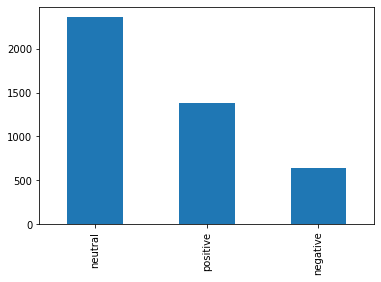

In [3]:
dirty_df.Sentiment.value_counts().plot(kind='bar')

In [22]:
def clean_sentence(s):
    # To lowercase
    s = s.lower()

    # Remove apostrophes
    s = re.sub(' \'s', '', s)

    # Fix % and $ whitespace
    s = re.sub('(?<=\d) %', '%', s)
    s = re.sub('\$ (?=\d)', '$', s)

    # Remove links
    s = re.sub('http\S+', ' ', s)

    # Remove .'s not surrounded by numbers
    s = re.sub('(?<!\d)\.|\,(?!\d)', '', s)

    # Remove punctuation
    s = re.sub('-|\(|\)', ' ', s)
    s = re.sub('\'|\,|\`|\:', '', s)

    # Remove extra whitespace
    s = re.sub(' +', ' ', s)

    return s

In [5]:
df = dirty_df.copy(deep=True)
df['Sentence'] = df['Sentence'].apply(clean_sentence)
df["Sentiment"] = df['Sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df

,Sentence,Sentiment
0,according to the finnish russian chamber of co...,0
1,the swedish buyout firm has sold its remaining...,0
2,$spy wouldnt be surprised to see a green close,1
3,shells $70 billion bg deal meets shareholder s...,-1
4,ssh communications security corp stock exchang...,-1
...,...,...
4377,investments in product development stood at 6....,0
4378,hsbc says unit to book $585 million charge on ...,-1
4379,rising costs have forced packaging producer hu...,-1
4380,in the building and home improvement trade sal...,0


In [6]:
def create_ngrams(s, n):
    words = s.split()
    ngrams = []
    for i in range(n):
        to_zip = []
        for j in range(i + 1):
            start = j
            end = (-i + j)

            if start == 0 and end == 0:
                ngrams.append(words)
            elif start == 0:
                to_zip.append(words[:end])
            elif end == 0:
                to_zip.append(words[start:])
            else:
                to_zip.append(words[start:end])
        if i > 0:
            ngrams.append([' '.join(x) for x in list(zip(*to_zip))])
        
    return sum(ngrams, [])

create_ngrams('a b c d', 3)

['a', 'b', 'c', 'd', 'a b', 'b c', 'c d', 'a b c', 'b c d']

In [7]:
df['ngrams'] = df['Sentence'].apply(create_ngrams, n=3)
df.head()

,Sentence,Sentiment,ngrams
0,according to the finnish russian chamber of co...,0,"[according, to, the, finnish, russian, chamber..."
1,the swedish buyout firm has sold its remaining...,0,"[the, swedish, buyout, firm, has, sold, its, r..."
2,$spy wouldnt be surprised to see a green close,1,"[$spy, wouldnt, be, surprised, to, see, a, gre..."
3,shells $70 billion bg deal meets shareholder s...,-1,"[shells, $70, billion, bg, deal, meets, shareh..."
4,ssh communications security corp stock exchang...,-1,"[ssh, communications, security, corp, stock, e..."


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.ngrams, df.Sentiment)

In [9]:
wordCount = defaultdict(int)
for s in df.Sentence:
    for w in create_ngrams(s, 3):
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [10]:
words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))

In [11]:
def feature(ng):
    feat = [0]*len(words)
    for w in ng:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [12]:
X_train = [feature(ng) for ng in X_train]
X_test = [feature(ng) for ng in X_test]

In [13]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X_train, y_train)
theta = clf.coef_
preds = clf.predict(X_test)

In [14]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()

In [15]:
print("1,000 most common n-grams")
print("--------------------------")
print("MSE: " + str(sum((y_test - preds)**2)/len(y_test)))
print()
print("most negative n-grams")
[print(w) for w in wordSort[:5]]
print()
print("most positive n-grams")
[print(w) for w in wordSort[:-6:-1]]
print()

1,000 most common n-grams
--------------------------
MSE: 0.39380989778731545

most negative n-grams
(-0.7424033928705481, 'x')
(-0.7302508447114149, 'decreased')
(-0.7088036783112336, 'fell')
(-0.6825193614016296, 'down')
(-0.6700626332925115, 'long term')

most positive n-grams
(0.7383420883841025, 'rise')
(0.6805502716181278, 'positive')
(0.6737467054659732, 'awarded')
(0.6610758125819074, 'grew')
(0.587528077912381, 'calls')



In [16]:
# Regularized regression
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test, y_test)

C:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6487226277372263

In [23]:
for s in dirty_df.Sentence[:100]:
    print(s)
    print(clean_sentence(s))
    print()

According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .
according to the finnish russian chamber of commerce all the major construction companies of finland are operating in russia 

The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after taking the company public in Finland .
the swedish buyout firm has sold its remaining 22.4 percent stake almost eighteen months after taking the company public in finland 

$SPY wouldn't be surprised to see a green close
$spy wouldnt be surprised to see a green close

Shell's $70 Billion BG Deal Meets Shareholder Skepticism
shells $70 billion bg deal meets shareholder skepticism

SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .
ssh communications security corp stock exchange release october 14 2008 a